Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [7]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

In [8]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [9]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [22]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def data_type():
    return tf.float32

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [35]:
batch_size = 256
patch_size = 5
depth = 32
num_hidden = 64
num_fc = 512
SEED = 1488

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_valid_labels = tf.constant(valid_labels)
    tf_test_dataset = tf.constant(test_dataset)
    tf_test_labels = tf.constant(test_labels)
  
    # Variables.
    train_size = train_labels.shape[0]

    conv1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], # 5x5 filter, depth 32.
                                                    stddev=0.1,
                                                    seed=SEED, dtype=data_type()))               
    conv1_biases = tf.Variable(tf.zeros([depth], dtype=data_type()))
    
    conv2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, num_hidden], 
                                                    stddev=0.1,
                                                    seed=SEED, dtype=data_type()))
    
    conv2_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden], dtype=data_type()))
    
    fc1_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * num_hidden, num_fc],
                                                  stddev=0.1,
                                                  seed=SEED,
                                                  dtype=data_type()))
    fc1_biases = tf.Variable(tf.constant(0.1, shape=[num_fc], dtype=data_type()))
    
    fc2_weights = tf.Variable(tf.truncated_normal([num_fc, num_labels],
                                                  stddev=0.1,
                                                  seed=SEED,
                                                  dtype=data_type()))
    fc2_biases = tf.Variable(tf.constant(0.1, shape=[num_labels], dtype=data_type()))
  
    def model(data, train=False):
        """The Model definition."""
        # 2D convolution, with 'SAME' padding (i.e. the output feature map has
        # the same size as the input). Note that {strides} is a 4D array whose
        # shape matches the data layout: [image index, y, x, depth].
        conv = tf.nn.conv2d(data,
                            conv1_weights,
                            strides=[1, 1, 1, 1],
                            padding='SAME')
        # Bias and rectified linear non-linearity.
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
        # Max pooling. The kernel size spec {ksize} also follows the layout of
        # the data. Here we have a pooling window of 2, and a stride of 2.
        pool = tf.nn.max_pool(relu,
                              ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1],
                              padding='SAME')
        conv = tf.nn.conv2d(pool,
                            conv2_weights,
                            strides=[1, 1, 1, 1],
                            padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
        pool = tf.nn.max_pool(relu,
                              ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1],
                              padding='SAME')
        # Reshape the feature map cuboid into a 2D matrix to feed it to the
        # fully connected layers.
        pool_shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool,[pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])

        # Fully connected layer. Note that the '+' operation automatically
        # broadcasts the biases.

        hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)

        # Add a 50% dropout during training only. Dropout also scales
        # activations such that no rescaling is needed at evaluation time.
        if train:
            hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
        return tf.matmul(hidden, fc2_weights) + fc2_biases

  
    # Training computation.
    logits = model(tf_train_dataset, True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                  tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
    loss += 5e-4 * regularizers

    
    # Optimizer: set up a variable that's incremented once per batch and
    # controls the learning rate decay.
    batch = tf.Variable(0, dtype=data_type())
    # Decay once per epoch, using an exponential schedule starting at 0.01.
    learning_rate = tf.train.exponential_decay(
        0.01,                # Base learning rate.
        batch * batch_size,  # Current index into the dataset.
        train_size,          # Decay step.
        0.95,                # Decay rate.
        staircase=True)
    
    
    # Use simple momentum for the optimization.
    optimizer = tf.train.MomentumOptimizer(learning_rate,0.9).minimize(loss,global_step=batch)
  

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

Minibatch loss at step 9000: 1.891793
Minibatch accuracy: 89.8%
Validation accuracy: 91.4%


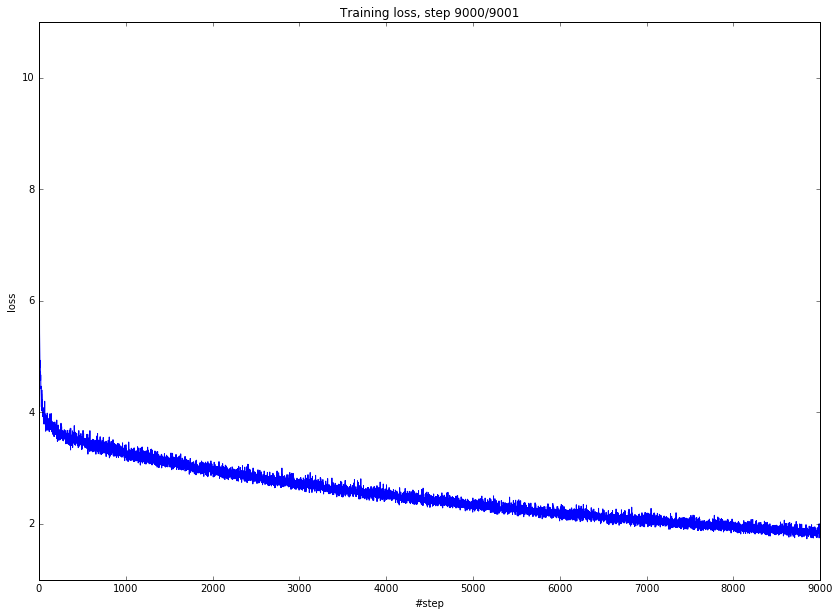

Test accuracy: 96.5%


In [36]:
num_steps = 9001
PFREQ = 100
lh = []

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized!')
    
    for step in range(num_steps):
    
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        lh.append(l)
        
        if (step % PFREQ == 0):
            display.clear_output(wait=True)
            
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
            
            plt.figure(figsize=(14, 10))

            plt.title("Training loss, step {}/{}".format(step, num_steps))
            plt.xlabel("#step")
            plt.ylabel("loss")
            plt.plot(lh, 'b')
            plt.show()
        
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---